# Intro to activation functions and parameter initialisers

In this notebook we will have a quick look at activation functions and how the choice of parameter initialisation methods affect the training of a neural network.

As a little reminder, the _activation function_ is a nonlinear transformation applied to the output values of each node in the network. Before we start training the network, the parameters (weights) of each connection between the nodes must be set to some value. We choose these values at random, but randoms numbers always come from some _distribution_, and there are good ways and less-good ways of selecting this distribution.

Tuning the parameter values are done by computing the _gradients_ with respect to the loss, and here we will write our own training loop (instead of using `model.fit()`), so that we can study these gradients in more detail.

First, the imports.

In [1]:
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt

### Activation functions

Let us plot some activation functions, in order to compare them. Let's start with ReLU and the sigmoid.

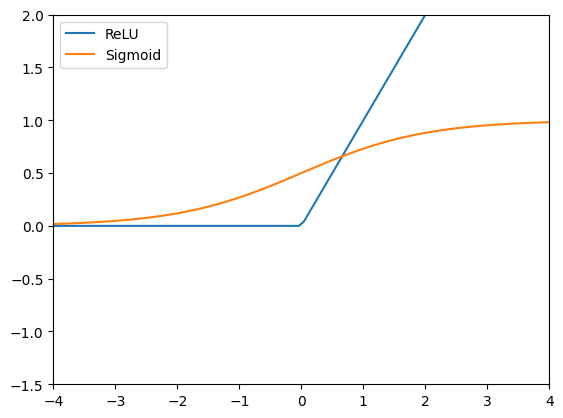

In [2]:
x = np.linspace(-4, 4, 100)

relu = keras.activations.relu(x)
sigmoid = keras.activations.sigmoid(x)

plt.plot(x, relu, label='ReLU')
plt.plot(x, sigmoid, label='Sigmoid')
plt.xlim((-4, 4))
plt.ylim((-1.5, 2.0))
plt.legend(loc='upper left')


### <span style="color: red;">Exercise:<span>

Add the other activation functions available in Keras (listed [here](https://keras.io/api/layers/activations/)), and plot them.

In [ ]:
y = np.linspace(-4, 4, 100)

celu = keras.activations.celu(y)
elu = keras.activations.elu(y)
exponential = keras.activations.exponential(y)
gelu = keras.activations.gelu(y)
glu = keras.activations.glu(y)
hard_shrink = keras.activations.hard_shrink(y)

plt.plot(y, celu, label="celu")
plt.plot(y, elu, label="elu")
plt.plot(y, exponential, label="expontential")
plt.plot(y, gelu, label="gelu")
plt.plot(y, glu, label="glu")
plt.plot(y, hard_shrink, label="Hard shrink")

### Load the data

In this example we stick to very simple data -- classification of 2-dimensional data, which form two circles.

Scikit-learn has a couple of convenience functions for creating simple datasets, and you can also choose some other data if you like.

In [ ]:
from sklearn.datasets import make_circles

X_train, y_train = make_circles(n_samples=500, noise=0.1)
X_test, y_test = make_circles(n_samples=100, noise=0.1)

plt.scatter(x=X_train[:, 0], y=X_train[:, 1], c=y_train, cmap='viridis')

The data are now in NumPy format, which is in principle fine, but for our custom training loop it will be more practical to have the data in TensorFlow Dataset (`tf.data.Dataset`) from. We get back to this next week, but for now, let's just accept the code below.

In [ ]:
batch_size = 64

# Train dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

# Test dataset
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(batch_size)

## Training loop

Here comes the exciting bit, our custom training loop, which computes the gradients and tunes the network parameters accordingly.

To compute the gradients, we need to run our model and compute the loss, and then the `GradientTape` fixes the rest. For this experiment we want to keep track of the gradients so we can plot them later, but remember there is one gradient per parameter in the network, which is usually a lot. To reduce the information a bit we can either compute the average of all of them, or we can also compute the L2 norm, which we know from before. In this case we use the L2 norm, but you are free to change it. In any case, let's average over the gradients in each layer individually, so we can see what the different layers are up to.

More information about custom training loops can be found here: https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch

In [ ]:
def training_loop(model, optimiser, loss_function, num_epochs=100):

    # Log the gradients
    gradients_L2 = []

    for epoch in range(num_epochs):

        # Iterate over the batches of the dataset.
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):

            with tf.GradientTape() as tape:
                # Run the forward pass of the layer.
                # The operations that the layer applies
                # to its inputs are going to be recorded
                # on the GradientTape.
                preds = model(x_batch_train, training=True)

                # Compute the loss value for this minibatch.
                loss_value = loss_function(y_batch_train, preds)

            # Use the gradient tape to automatically retrieve
            # the gradients of the trainable variables with respect to the loss.
            grads = tape.gradient(loss_value, model.trainable_weights)

            # Extract the L2 norm of the gradients
            L2 = []
            for grad in grads:
                if len(grad.shape) != 1:    # skip biases, look only at weights
                    L2.append(tf.norm(grad).numpy())

            gradients_L2.append(L2)

            # Run one step of gradient descent by updating
            # the value of the variables to minimize the loss.
            optimiser.apply_gradients(zip(grads, model.trainable_weights))

        # Epoch end
        print(f'Epoch {epoch}: train loss = {model.evaluate(train_dataset, verbose=0)}, test loss = {model.evaluate(test_dataset,verbose=0)}')

    return gradients_L2

## Define the model

Now, since we want to test out different activation function and initialiser combinations, we can define a function that creates a neural network for the given combinations.

In [ ]:
def create_model(activation, initializer):

    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=(2,)))

    model.add(keras.layers.Dense(units=10, activation=activation, kernel_initializer=initializer))
    model.add(keras.layers.Dense(units=10, activation=activation, kernel_initializer=initializer))
    model.add(keras.layers.Dense(units=10, activation=activation, kernel_initializer=initializer))

    model.add(keras.layers.Dense(units=1, activation='sigmoid'))

    model.summary()

    return model

For the first test, let's try a configuration that was common in the 90s: The sigmoid activation function, and initialising the parameters from a uniform (i.e. a flat) distribution.



In [ ]:
initializer = keras.initializers.RandomUniform(minval=0, maxval=1)
activation = 'sigmoid'
#initializer = keras.initializers.HeUniform()
#activation = 'relu'

# Create model
sigmoid_model = create_model(activation, initializer)

# Compile it
optimizer = keras.optimizers.SGD(learning_rate=0.1)
loss_fn = keras.losses.BinaryCrossentropy()

sigmoid_model.compile(optimizer=optimizer, loss=loss_fn)

## Train the first model

Time to train the first model!

In [ ]:
grads_L2 = training_loop(sigmoid_model, optimizer, loss_fn)

## Evaluate the first model

First, investigate the model's performance simply by looking at how the _decision boundary_ matches with the test data points:

In [ ]:
from sklearn.inspection import DecisionBoundaryDisplay

def plot_decision_boundary(model):

    feature_1, feature_2 = np.meshgrid(
        np.linspace(-1.5, 1.5, 20),
        np.linspace(-1.5, 1.5, 20)
    )

    grid = np.vstack([feature_1.ravel(), feature_2.ravel()]).T
    y_pred = np.reshape(model.predict(grid), feature_1.shape)

    display = DecisionBoundaryDisplay(
        xx0=feature_1, xx1=feature_2, response=y_pred
    )
    display.plot()

    plt.scatter(x=X_test[:, 0], y=X_test[:, 1], c=y_test, cmap='viridis')



plot_decision_boundary(sigmoid_model)

And now we look at the history of the gradients:

In [ ]:
grads_L2 = np.array(grads_L2)

for i in range(grads_L2.shape[1]):
    plt.plot(np.arange(grads_L2.shape[0]), grads_L2[:,i], label=f'Layer {i}', alpha=0.7)

plt.ylabel('L2 value')
plt.xlabel('Epoch')
plt.legend()

## Train and evaluate the second model

This time around, we try a similar model but where activation function and initialistion methods is chosen differently:

In [ ]:
initializer = keras.initializers.HeUniform()
activation = 'relu'

# Create model
relu_model = create_model(activation, initializer)

# Compile it
optimizer = keras.optimizers.SGD(learning_rate=0.2)
loss_fn = keras.losses.BinaryCrossentropy()

relu_model.compile(optimizer=optimizer, loss=loss_fn)

Train it

In [ ]:
grads_L2 = training_loop(relu_model, optimizer, loss_fn)

... and plot the results:

In [ ]:
plot_decision_boundary(relu_model)

Let's also look at the gradients:

In [ ]:
grads_L2 = np.array(grads_L2)

for i in range(grads_L2.shape[1]):
    plt.plot(np.arange(grads_L2.shape[0]), grads_L2[:,i], label=f'Layer {i}', alpha=0.7)

plt.ylabel('L2 value')
plt.xlabel('Epoch')
plt.legend()

### <span style="color: red;">Exercise:<span>

1) Look at the decision boundaries. Which model performs best? Can you make them perform equally good by changing the learning rate?
2) Look at the gradient plots. Do the different layers in the model show equal gradient values? What can you say by comparing the curves?